In [22]:
# Import libraries

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import json
import asyncio
from sklearn import datasets
from tqdm import tqdm
import os
import time

os.environ['ENABLE_ICICLE_GPU'] = 'true'
os.environ['RUST_BACKTRACE']='full'

# check if notebook is in colab
try:
    # install ezkl
    import google.colab
    import subprocess
    import sys
    subprocess.check_call([sys.executable, "-m", "pip", "install", "ezkl"])
    subprocess.check_call([sys.executable, "-m", "pip", "install", "onnx"])
    subprocess.check_call([sys.executable, "-m", "pip", "install", "nest_asyncio"])

# rely on local installation of ezkl if the notebook is not in colab
except:
    pass

import ezkl
import os
import nest_asyncio

nest_asyncio.apply()

# Task definition

print('Data information')
print('=' * 20)

images, labels = datasets.load_digits(return_X_y=True)
images = torch.tensor(images, dtype=torch.float32)
labels = torch.tensor(labels, dtype=torch.int64)
print(f'#samples={len(images)}, image_size={images[0].shape}')

mask = labels % 2 == 1
odd_num_images, odd_num_labels = images[mask], labels[mask]
print(f'#odd_num_images={len(odd_num_images)}')

mask = labels % 2 == 0
even_num_images, even_num_labels = images[mask], labels[mask]
print(f'#even_num_images={len(even_num_images)}')

# Neural network definition
hidden_dim = 256
input_dim = 64
output_dim = 10
num_params = (1 + input_dim) * hidden_dim + (1 + hidden_dim) * output_dim
print(f'num_params={num_params}')


class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


def get_loss(model, data, labels):
    logits = model(data)
    log_probs = F.log_softmax(logits, dim=1)
    true_log_probs = log_probs.gather(1, labels.view(-1, 1))
    return -true_log_probs.mean()


def get_grad(model, data, labels):
    model.zero_grad()
    loss = get_loss(model, data, labels)
    loss.backward()
    return model.parameters()


def get_acc(logits, labels):
    predicted_labels = logits.argmax(dim=1)
    return (predicted_labels == labels).float().mean().item()


def train(model, x, y, lr=0.003, num_epochs=10):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    for _ in range(num_epochs):
        optimizer.zero_grad()
        loss = get_loss(model, x, y)
        loss.backward()
        optimizer.step()
    return model


# Test
mlp = MLP()
rand_params = torch.randn(num_params) * 0.01
mlp.fc1.weight.data = rand_params[:hidden_dim * input_dim].view(hidden_dim, input_dim)
mlp.fc1.bias.data = rand_params[hidden_dim * input_dim:hidden_dim * input_dim + hidden_dim]
mlp.fc2.weight.data = rand_params[-(output_dim * hidden_dim + output_dim):-output_dim].view(output_dim, hidden_dim)
mlp.fc2.bias.data = rand_params[-output_dim:]


Data information
#samples=1797, image_size=torch.Size([64])
#odd_num_images=906
#even_num_images=891
num_params=19210


In [23]:
print(images.shape)
logits = mlp(images)
loss = get_loss(mlp, images, labels)
acc = get_acc(logits, labels)
print(f'Random MLP: loss={loss.item():.4f}, acc={acc:.2f}')

# Train 2 seed MLPs
mlp1 = MLP()
mlp2 = MLP()

mlp1 = train(mlp1, odd_num_images, odd_num_labels)
mlp2 = train(mlp2, even_num_images, even_num_labels)

models = [mlp1, mlp2]
model_names = ['mlp1', 'mlp2']
for model, model_name in zip(models, model_names):
    for x, y, name in zip([odd_num_images, even_num_images, images], [odd_num_labels, even_num_labels, labels], ['d_odd', 'd_even', 'd0-9']):
        logits = model(x)
        acc = get_acc(logits, y)
        print(f'{model_name} acc@{name}={acc:.2f}')
    print('-' * 10)



torch.Size([1797, 64])
Random MLP: loss=2.3048, acc=0.09
mlp1 acc@d_odd=0.97
mlp1 acc@d_even=0.00
mlp1 acc@d0-9=0.49
----------
mlp2 acc@d_odd=0.00
mlp2 acc@d_even=0.98
mlp2 acc@d0-9=0.49
----------


In [39]:
# Evolutionary algorithm merging class and function definitions
#n_iter = 1000
#n_iter = 10
#n_iter = 20
n_iter = 5
mutation_std = 0.01
#pop_size = 512
#num_elite = 4
#pop_size = 10

pop_size = 10
num_elite = 4
seed = 42

class Slerp(nn.Module):
    def __init__(self):
        super(Slerp, self).__init__()

    '''
    def forward(self, val, x, y):
      norm_x = F.normalize(x, dim=-1)
      norm_y = F.normalize(y, dim=-1)
      dot = torch.sum(norm_x * norm_y, dim=-1, keepdim=True)
      omega = torch.acos(torch.clamp(dot, -1.0, 1.0))
      sin_omega = torch.sin(omega)
      scale_x = torch.sin((1.0 - val) * omega) / sin_omega
      scale_y = torch.sin(val * omega) / sin_omega
      lin_scale_x = 1.0 - val
      lin_scale_y = val
      return torch.where(sin_omega > 1e-6, scale_x * x + scale_y * y, lin_scale_x * x + lin_scale_y * y)
    '''
    def forward(self, val, x, y):
        return val*x + (1-val)*y

class Mutate(nn.Module):
    def __init__(self, mutation_std):
        super(Mutate, self).__init__()
        self.mutation_std = mutation_std

    def forward(self, rand_num, gene):
        noise = rand_num*self.mutation_std
        return gene + noise

slerp = Slerp()
mutate = Mutate(mutation_std)
RUN_FOLDER = './test_merge_dir/'

from pathlib import Path
Path(RUN_FOLDER).mkdir(parents=True, exist_ok=True) # create directory and any intermediate directories

#import ipdb
'''
def crossover(parents):
    w = torch.rand(1)
    return slerp(w, parents[0], parents[1])
'''
async def calibrate_mutate(rand_num, model, mutate_fn):
    model_path = os.path.join(RUN_FOLDER + 'mutate.onnx')
    compiled_model_path = os.path.join(RUN_FOLDER + 'mutate_network.compiled')
    pk_path = os.path.join(RUN_FOLDER + 'mutate_test.pk')
    vk_path = os.path.join(RUN_FOLDER + 'mutate_test.vk')
    settings_path = os.path.join(RUN_FOLDER + 'mutate_settings.json')
    
    witness_path = os.path.join(RUN_FOLDER + 'mutate_witness.json')
    data_path = os.path.join(RUN_FOLDER + 'mutate_input.json')
    
    torch.onnx.export(
        mutate_fn,                       # the model/module to be exported
        (rand_num, model),                 # example inputs
        model_path,                # the file name to save the ONNX model
        export_params=True,          # store the trained parameter weights inside the model file
        opset_version=11,            # the ONNX version to export the model to
        do_constant_folding=True,    # whether to execute constant folding for optimization
        input_names=['rand_num', 'model'],  # input names
        output_names=['mutated_weights']        # output name
    )
    
    py_run_args = ezkl.PyRunArgs()
    py_run_args.input_visibility = "public"
    py_run_args.output_visibility = "public"
    # assuming params for mutate are none (model params are considered inputs in this case, right?)
    py_run_args.param_visibility = "fixed" # "fixed" for params means that the committed to params are used for all proofs

    res = ezkl.gen_settings(model_path, settings_path, py_run_args=py_run_args)

    assert res == True

    data = dict(input_data = [rand_num.detach().numpy().reshape(-1).tolist(), 
                              torch.rand(*model.shape).detach().numpy().reshape(-1).tolist()])
    cal_path = os.path.join(RUN_FOLDER + "mutate_calibration.json")

    json.dump(data, open(cal_path, 'w'))

    await ezkl.calibrate_settings(cal_path, model_path, settings_path, "resources")

    res = ezkl.compile_circuit(model_path, compiled_model_path, settings_path)
    assert res == True

    # srs path
    res = ezkl.get_srs( settings_path)

    # HERE WE SETUP THE CIRCUIT PARAMS
    # WE GOT KEYS
    # WE GOT CIRCUIT PARAMETERS
    # EVERYTHING ANYONE HAS EVER NEEDED FOR ZK
    
    res = ezkl.setup(
            compiled_model_path,
            vk_path,
            pk_path,
        )
    
    assert res == True

async def calibrate_circuit(val, parent_1, parent_2):
    model_path = os.path.join(RUN_FOLDER + 'slerp.onnx')
    compiled_model_path = os.path.join(RUN_FOLDER + 'network.compiled')
    pk_path = os.path.join(RUN_FOLDER + 'merge_test.pk')
    vk_path = os.path.join(RUN_FOLDER + 'merge_test.vk')
    settings_path = os.path.join(RUN_FOLDER + 'settings.json')
    
    witness_path = os.path.join(RUN_FOLDER + 'witness.json')
    data_path = os.path.join(RUN_FOLDER + 'slerp_input.json')
    torch.onnx.export(
        slerp,                       # the model/module to be exported
        (val, parent_1, parent_2),                 # example inputs
        model_path,                # the file name to save the ONNX model
        export_params=True,          # store the trained parameter weights inside the model file
        opset_version=11,            # the ONNX version to export the model to
        do_constant_folding=True,    # whether to execute constant folding for optimization
        input_names=['val', 'parent_1', 'parent_2'],  # input names
        output_names=['merged_weights']        # output name
        #dynamic_axes={'x': {0: 'batch_size'}, 'y': {0: 'batch_size'}, 'result': {0: 'batch_size'}}  # no dynamic axis for merging
    )

    py_run_args = ezkl.PyRunArgs()
    py_run_args.input_visibility = "public"
    py_run_args.output_visibility = "public"
    # assuming params for slerp are none (model params are considered inputs in this case, right?)
    py_run_args.param_visibility = "fixed" # "fixed" for params means that the committed to params are used for all proofs

    res = ezkl.gen_settings(model_path, settings_path, py_run_args=py_run_args)
    assert res == True
    
    data = dict(input_data = [[val.item()], 
                              torch.rand(*parent_1.shape).detach().numpy().reshape(-1).tolist(), 
                              torch.rand(*parent_2.shape).detach().numpy().reshape(-1).tolist()])
    cal_path = os.path.join(RUN_FOLDER + "calibration.json")

    json.dump(data, open(cal_path, 'w'))

    await ezkl.calibrate_settings(cal_path, model_path, settings_path, "resources")
    #await ezkl.calibrate_settings(cal_path, model_path, settings_path)

    res = ezkl.compile_circuit(model_path, compiled_model_path, settings_path)
    assert res == True

    # srs path
    res = ezkl.get_srs( settings_path)

    # HERE WE SETUP THE CIRCUIT PARAMS
    # WE GOT KEYS
    # WE GOT CIRCUIT PARAMETERS
    # EVERYTHING ANYONE HAS EVER NEEDED FOR ZK
    
    res = ezkl.setup(
            compiled_model_path,
            vk_path,
            pk_path,
        )
    
    assert res == True
    

async def zk_prove_merge(val, merge_idx, parent_1, parent_2, iteration, parent_ind_1, parent_ind_2):
    merge_id = 'iter_' + str(iteration) + '_merge_idx_' + str(merge_idx) + '_p1_' + str(parent_ind_1.item()) + '_p2_' + str(parent_ind_2.item())
    model_path = os.path.join(RUN_FOLDER + 'slerp.onnx')
    compiled_model_path = os.path.join(RUN_FOLDER + 'network.compiled')
    #pk_path = os.path.join(RUN_FOLDER + merge_id + '_test.pk')
    #vk_path = os.path.join(RUN_FOLDER + merge_id + '_test.vk')
    pk_path = os.path.join(RUN_FOLDER + 'merge_test.pk')
    vk_path = os.path.join(RUN_FOLDER + 'merge_test.vk')
    settings_path = os.path.join(RUN_FOLDER + 'settings.json')

    witness_path = os.path.join(RUN_FOLDER + 'witness.json')
    data_path = os.path.join(RUN_FOLDER + 'slerp_input_' + merge_id + '.json')

    # now generate the witness file

    data = dict(input_data = [[val.item()], 
                              parent_1.detach().numpy().reshape(-1).tolist(), 
                              parent_2.detach().numpy().reshape(-1).tolist()])
    with open(data_path, "w") as f:
        json.dump(data, f)
    res = await ezkl.gen_witness(data_path, compiled_model_path, witness_path)
    assert os.path.isfile(witness_path)


    assert os.path.isfile(vk_path)
    assert os.path.isfile(pk_path)
    assert os.path.isfile(settings_path)

    # GENERATE A PROOF

    proof_path = os.path.join(RUN_FOLDER + merge_id + '_test.pf')
    '''
    proof = ezkl.prove(
            witness_path,
            compiled_model_path,
            pk_path,
            proof_path,

            "single",
        )
    '''
    proof = ezkl.prove(
            witness_path,
            compiled_model_path,
            pk_path,
            proof_path,

            "for-aggr",
        )
    assert os.path.isfile(proof_path)
    return proof


def crossover(parents, iteration, parent_inds, merge_idx):
    val = torch.rand(1)
    loop = asyncio.get_event_loop()
    proof = loop.run_until_complete(zk_prove_merge(val, merge_idx, parents[0], parents[1], iteration, parent_inds[0], parent_inds[1]))
    #proof = None
    result = slerp(val, parents[0], parents[1])
    return result, proof

'''
def mutate(gene, rand_num):
    noise = rand_num * mutation_std
    return gene + noise
'''


async def prove_mutate(rand_num, model, merge_idx, iteration):
    merge_id = 'iter_' + str(iteration) + '_merge_idx_' + str(merge_idx) + '_mutate'
    model_path = os.path.join(RUN_FOLDER + 'mutate.onnx')
    compiled_model_path = os.path.join(RUN_FOLDER + 'mutate_network.compiled')
    #pk_path = os.path.join(RUN_FOLDER + merge_id + '_mutate_test.pk')
    #vk_path = os.path.join(RUN_FOLDER + merge_id + '_mutate_test.vk')
    pk_path = os.path.join(RUN_FOLDER + 'mutate_test.pk') # these can be the same as the calibrated ones?
    vk_path = os.path.join(RUN_FOLDER + 'mutate_test.vk')
    settings_path = os.path.join(RUN_FOLDER + 'mutate_settings.json')
    
    witness_path = os.path.join(RUN_FOLDER + 'mutate_witness.json')
    data_path = os.path.join(RUN_FOLDER + 'mutate_input.json')

    # now generate the witness file

    data = dict(input_data = [rand_num.detach().numpy().reshape(-1).tolist(), 
                              model.detach().numpy().reshape(-1).tolist()])
    with open(data_path, "w") as f:
        json.dump(data, f)
    res = await ezkl.gen_witness(data_path, compiled_model_path, witness_path)
    assert os.path.isfile(witness_path)

    '''
    # HERE WE SETUP THE CIRCUIT PARAMS
    # WE GOT KEYS
    # WE GOT CIRCUIT PARAMETERS
    # EVERYTHING ANYONE HAS EVER NEEDED FOR ZK
    
    res = ezkl.setup(
            compiled_model_path,
            vk_path,
            pk_path,
        )
    '''

    assert os.path.isfile(vk_path)
    assert os.path.isfile(pk_path)
    assert os.path.isfile(settings_path)

    # GENERATE A PROOF

    proof_path = os.path.join(RUN_FOLDER + merge_id + '_test.pf')

    '''
    proof = ezkl.prove(
            witness_path,
            compiled_model_path,
            pk_path,
            proof_path,
            "single",
        )
    '''
    proof = ezkl.prove(
            witness_path,
            compiled_model_path,
            pk_path,
            proof_path,
            "for-aggr",
        )
    
    assert os.path.isfile(proof_path)
    return proof

def ask(elite_solutions, iteration, mutate_fn):
    parents_indices = torch.randint(0, elite_solutions.shape[0], (pop_size * 2,))
    #ipdb.set_trace()
    parents = elite_solutions[parents_indices].view(pop_size, 2, -1)
    p_inds = parents_indices.view(pop_size, 2)
    #population = torch.stack([crossover(p, iteration, p_inds[i]) for i, p in enumerate(parents)])
    pop_list = []
    proof_list = []
    for merge_idx, p in enumerate(parents):
        merged_model, proof = crossover(p, iteration, p_inds[merge_idx], merge_idx)
        pop_list.append(merged_model)
        proof_list.append(proof)
    population = torch.stack(pop_list)
    pop = []
    mutate_proof_list = []
    loop = asyncio.get_event_loop()
    for merge_idx, g in enumerate(population):
        rand_num = torch.randn(g.shape)
        proof = loop.run_until_complete(prove_mutate(rand_num, g, merge_idx, iteration))
        pop.append([mutate(rand_num, g) for g in population])
        mutate_proof_list.append(proof)
        
    return population, proof_list, mutate_proof_list, p_inds

def get_flat_params(model):
    return torch.concatenate([p.view(-1) for p in model.parameters()])

def tell(population, scores, proofs):
    top_scores, top_indices = scores.topk(num_elite)
    new_elites = population[top_indices]
    new_elites_proofs = [proofs[idx] for idx in top_indices]
    new_elites[-1] = get_flat_params(mlp1)
    new_elites[-2] = get_flat_params(mlp2)
    return new_elites, new_elites_proofs, top_indices

def reroll_params(flat_params):
    model = MLP()
    
    # Load the model's parameters from the flattened params vector, reshaping the weights
    model.fc1.weight.data = flat_params[:hidden_dim * input_dim].view(hidden_dim, input_dim)

    model.fc1.bias.data = flat_params[(hidden_dim * input_dim):(hidden_dim * input_dim + hidden_dim)]

    model.fc2.weight.data = flat_params[-(output_dim * hidden_dim + output_dim):-output_dim].view(output_dim, hidden_dim)

    model.fc2.bias.data = flat_params[-output_dim:]
    return model

def eval_params(params, x, y):
    model = reroll_params(params)

    # Reshape the input data to match the expected input size of the model
    x_reshaped = x.view(-1, input_dim)  # Reshape to [batch_size, input_dim]

    logits = model(x_reshaped)  # Pass the reshaped input to the model
    return get_acc(logits, y)
    

In [40]:
# Initialize the elites with seed models
mlp1_param = torch.concatenate([mlp1.state_dict()['fc1.weight'].view(-1), mlp1.state_dict()['fc1.bias'].view(-1), mlp1.state_dict()['fc2.weight'].view(-1), mlp1.state_dict()['fc2.bias'].view(-1)])
mlp2_param = torch.concatenate([mlp2.state_dict()['fc1.weight'].view(-1), mlp2.state_dict()['fc1.bias'].view(-1), mlp2.state_dict()['fc2.weight'].view(-1), mlp2.state_dict()['fc2.bias'].view(-1)])
elites = torch.stack([mlp1_param, mlp2_param])
#elites = elites[torch.randint(0, 2, (num_elite,))]

# calibrate circuit
val = torch.rand(1)
loop = asyncio.get_event_loop()
calibrate_start = time.time()
verified = loop.run_until_complete(calibrate_circuit(val, mlp1_param, mlp2_param))
calibrate_end = time.time()
calibration_duration = calibrate_end - calibrate_start
print('Calibration duration: ' + str(calibration_duration))

mutate_calibrate_start = time.time()
rand_num = torch.randn(mlp1_param.shape)
verified = loop.run_until_complete(calibrate_mutate(rand_num, mlp1_param, mutate))
mutate_calibrate_end = time.time()
mutate_calibration_duration = mutate_calibrate_end - mutate_calibrate_start
print('Calibration duration: ' + str(calibration_duration))

Using 2 columns for non-linearity table.
Using 3 columns for non-linearity table.
Using 3 columns for non-linearity table.


 <------------- Numerical Fidelity Report (input_scale: 13, param_scale: 13, scale_input_multiplier: 10) ------------->

+------------------+---------------+---------------+---------------+----------------+------------------+---------------+---------------+--------------------+--------------------+------------------------+
| mean_error       | median_error  | max_error     | min_error     | mean_abs_error | median_abs_error | max_abs_error | min_abs_error | mean_squared_error | mean_percent_error | mean_abs_percent_error |
+------------------+---------------+---------------+---------------+----------------+------------------+---------------+---------------+--------------------+--------------------+------------------------+
| 0.00000011473114 | 0.00003707409 | 0.00010973215 | -0.0001052022 | 0.000028253957 | 0.00003707409    | 0.00010973215 | 0             | 0.000

Calibration duration: 13.32986044883728




 <------------- Numerical Fidelity Report (input_scale: 13, param_scale: 13, scale_input_multiplier: 10) ------------->

+-------------------+----------------+---------------+----------------+----------------+------------------+---------------+---------------+--------------------+--------------------+------------------------+
| mean_error        | median_error   | max_error     | min_error      | mean_abs_error | median_abs_error | max_abs_error | min_abs_error | mean_squared_error | mean_percent_error | mean_abs_percent_error |
+-------------------+----------------+---------------+----------------+----------------+------------------+---------------+---------------+--------------------+--------------------+------------------------+
| -0.00000039168586 | -0.00001257658 | 0.00008833408 | -0.00009213388 | 0.000031256393 | 0.00001257658    | 0.00009213388 | 0             | 0.000000001331557  | 0.00000071775656   | 0.000266997            |
+-------------------+----------------+-----------

Calibration duration: 13.32986044883728


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [03:51<00:00, 46.22s/it]

Evolutionary model merging with proof generation duration: 231.09783911705017


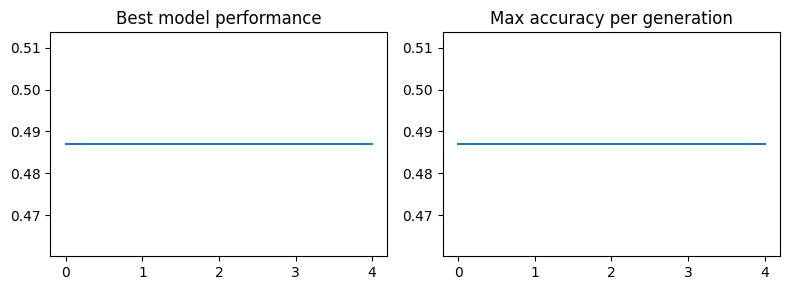

In [41]:
# Optimization loop
acc_max = []
merge_idx_and_p_inds = []

top_model_history = [] # list of parents of top model
all_model_histories = [] # list of lists of parents of current population of models

start_time = time.time()
for i in tqdm(range(n_iter)):
    population, proofs, mutate_proofs, p_inds = ask(elites, i, mutate)
    p_inds_w_merge_idx = torch.concatenate([torch.arange(pop_size).reshape(-1,1), p_inds], dim=1) # concatenated iteration number and all parent indices
    merge_idx_and_p_inds.append(p_inds_w_merge_idx)
    #print(population.shape)
    scores = torch.tensor([eval_params(p, images, labels) for p in population])
    #print('score values')
    #print(scores)
    #elites = tell(elites, scores)
    elites, new_elites_proofs, top_inds = tell(population, scores, proofs)
    acc_max.append(scores.max().item())

merge_idx_and_p_inds = torch.stack(merge_idx_and_p_inds)
best_ind = top_inds[0]

end_time = time.time()
duration = end_time - start_time
print('Evolutionary model merging with proof generation duration: ' + str(duration))
# Plot the results
fig, axes = plt.subplots(1, 2, figsize=(8, 3))

ax = axes[0]
ax.plot(np.maximum.accumulate(acc_max))
ax.set_title('Best model performance')
ax = axes[1]
ax.plot(acc_max)
ax.set_title('Max accuracy per generation')

plt.tight_layout()
plt.show()

In [63]:
print(merge_idx_and_p_inds)
async def verify_proofs(merge_id, mutate_id):
    proof_path = os.path.join(RUN_FOLDER + merge_id + '_test.pf')
    settings_path = os.path.join(RUN_FOLDER + 'settings.json')
    #vk_path = os.path.join(RUN_FOLDER + merge_id + '_test.vk')
    vk_path = os.path.join(RUN_FOLDER + 'merge_test.vk')

    #print(proof_path)
    #print(settings_path)
    #print(vk_path)
    assert os.path.isfile(proof_path)
    assert os.path.isfile(settings_path)
    assert os.path.isfile(vk_path)
    res = ezkl.verify(
        proof_path,
        settings_path,
        vk_path
    )
    assert res == True
    print("merge verified")

    proof_path = os.path.join(RUN_FOLDER + mutate_id + '_test.pf')
    settings_path = os.path.join(RUN_FOLDER + 'mutate_settings.json')
    #vk_path = os.path.join(RUN_FOLDER + mutate_id + '_mutate_test.vk')
    vk_path = os.path.join(RUN_FOLDER + 'mutate_test.vk')

    #print(proof_path)
    #print(settings_path)
    #print(vk_path)
    print(proof_path)
    print(settings_path)
    print(vk_path)
    assert os.path.isfile(proof_path)
    assert os.path.isfile(settings_path)
    assert os.path.isfile(vk_path)
    res = ezkl.verify(
        proof_path,
        settings_path,
        vk_path
    )
    assert res == True
    print("mutate verified")
    return res

async def aggregate_merge_and_mutate(merge_id, mutate_id):
    merge_proof_path = os.path.join(RUN_FOLDER + merge_id + '_test.pf')
    mutate_proof_path = os.path.join(RUN_FOLDER + mutate_id + '_test.pf')
    print('Aggregating ' + merge_proof_path + ' and ' + mutate_proof_path + ' ...')
    num_logrows = 24
    res = await ezkl.get_srs(settings_path=None, logrows=num_logrows, commitment=ezkl.PyCommitments.KZG)
    res = ezkl.mock_aggregate([merge_proof_path, mutate_proof_path], num_logrows)
    assert res == True

    aggregate_proof_path = os.path.join('aggr.pf')
    aggregate_vk_path = os.path.join('aggr.vk')
    aggregate_pk_path = os.path.join('aggr.pk')
    # Setup the vk and pk for aggregate
    res = ezkl.setup_aggregate(
        [merge_proof_path, mutate_proof_path],
        aggregate_vk_path,
        aggregate_pk_path,
        num_logrows
    )
    aggr_proof = ezkl.aggregate(
        [merge_proof_path, mutate_proof_path],
        aggregate_proof_path,
        aggregate_pk_path,
        "evm",
        num_logrows,
        "safe"
    )
    
    assert os.path.isfile(aggregate_proof_path)
    
    assert os.path.isfile(aggregate_vk_path)
    assert os.path.isfile(aggregate_pk_path)
    # Check if the proof is valid
    res = ezkl.verify_aggr(
        aggregate_proof_path,
        aggregate_vk_path,
        num_logrows,
    )
    assert res == True
    print('verified aggregate')

    return aggr_proof


async def verify_all_proofs(merge_idx_and_p_inds):
    merge_ids = []
    mutate_ids = []
    for iteration, merge_list in enumerate(merge_idx_and_p_inds):
        for merge in merge_list:
            merge_id = 'iter_' + str(iteration) + '_merge_idx_' + str(int(merge[0])) + '_p1_' + str(int(merge[1])) + '_p2_' + str(int(merge[2]))
            merge_ids.append(merge_id)
            mutate_id = 'iter_' + str(iteration) + '_merge_idx_' + str(int(merge[0])) + '_mutate'
            mutate_ids.append(mutate_id)
    await asyncio.gather(*(verify_proofs(merge_id, mutate_id) for (merge_id, mutate_id) in zip(merge_ids, mutate_ids)))


async def verify_only_best_path_proofs(merge_idx_and_p_inds, best_ind):
    # given the ending best performing model, get each proof in the tree of proofs that is necessary to prove the parent models
    parents_to_verify = [tuple(merge_idx_and_p_inds[-1][best_ind].tolist())] # get the parent indices of the best model of in the last iteration
    merge_ids = set()
    mutate_ids = set()
    all_ids = set()
    for iteration in reversed(range(len(merge_idx_and_p_inds))):
        # verify current parents
        new_parents = []
        for parents in parents_to_verify:
            print(parents_to_verify)
            merge_idx = parents[0]
            print('Model ' + str(merge_idx) + ' from iteration ' + str(iteration) + ' has parents ' + str(int(parents[1])) + ' and ' + str(int(parents[2])) + ' from iteration ' + str(iteration-1))
            merge_id = 'iter_' + str(int(iteration)) + '_merge_idx_' + str(int(merge_idx)) + '_p1_' + str(int(parents[1])) + '_p2_' + str(int(parents[2]))
            grandparents_p1 = tuple(merge_idx_and_p_inds[iteration-1][parents[1]].tolist())
            grandparents_p2 = tuple(merge_idx_and_p_inds[iteration-1][parents[2]].tolist())
            new_parents.append(grandparents_p1)
            new_parents.append(grandparents_p2)
            
            mutate_id = 'iter_' + str(iteration) + '_merge_idx_' + str(int(merge_idx)) + '_mutate'
            merge_ids.add(merge_id)
            mutate_ids.add(mutate_id)
            all_ids.add((merge_id, mutate_id))
            #print('The parents of ' + merge_id + ' are ' + 'iter_' + str(int(iteration-1)) + '_merge_idx_' + str(int(parents[0])) + '_p1_' + str(int(new_parents[0][1])) + '_p2_' + str(int(new_parents[0][2])) + ' and ' \
            #    'iter_' + str(int(iteration-1)) + '_merge_idx_' + str(int(parents[1])) + '_p1_' + str(int(new_parents[1][1])) + '_p2_' + str(int(new_parents[1][2])))
        print('Iteration ' + str(iteration))
        parents_to_verify = set(new_parents) # don't include the same parents twice
        print(parents_to_verify)
        print('number of parents to verify ' + str(len(parents_to_verify)))

    #return await asyncio.gather(*(verify_proofs(merge_id) for merge_id in merge_ids))
    #await asyncio.gather(*(aggregate_merge_and_mutate(merge_id, mutate_id) for (merge_id, mutate_id) in all_ids))
    await aggregate_merge_and_mutate(*(list(all_ids)[0]))
    return await asyncio.gather(*(verify_proofs(merge_id, mutate_id) for (merge_id, mutate_id) in all_ids))

tensor([[[0, 0, 1],
         [1, 0, 0],
         [2, 1, 0],
         [3, 1, 1],
         [4, 0, 1],
         [5, 0, 0],
         [6, 0, 1],
         [7, 1, 0],
         [8, 1, 1],
         [9, 1, 0]],

        [[0, 1, 3],
         [1, 1, 2],
         [2, 2, 3],
         [3, 0, 1],
         [4, 1, 1],
         [5, 2, 0],
         [6, 0, 1],
         [7, 2, 2],
         [8, 1, 2],
         [9, 3, 3]],

        [[0, 0, 3],
         [1, 1, 2],
         [2, 1, 1],
         [3, 3, 0],
         [4, 2, 0],
         [5, 1, 1],
         [6, 3, 2],
         [7, 2, 3],
         [8, 3, 1],
         [9, 1, 1]],

        [[0, 2, 2],
         [1, 0, 1],
         [2, 3, 2],
         [3, 1, 3],
         [4, 2, 3],
         [5, 2, 0],
         [6, 3, 3],
         [7, 1, 2],
         [8, 1, 3],
         [9, 1, 3]],

        [[0, 2, 0],
         [1, 0, 0],
         [2, 3, 1],
         [3, 3, 2],
         [4, 1, 1],
         [5, 3, 0],
         [6, 2, 0],
         [7, 0, 3],
         [8, 1, 1],
         [9,

In [ ]:
verify_start = time.time()
best_ind = top_inds[0]
await verify_only_best_path_proofs(merge_idx_and_p_inds, best_ind)
verify_end = time.time()

verify_duration = verify_end - verify_start
print('Proof verification duration (best path):' + str(verify_duration))

[(8, 1, 1)]
Model 8 from iteration 4 has parents 1 and 1 from iteration 3
Iteration 4
{(1, 0, 1)}
number of parents to verify 1
{(1, 0, 1)}
Model 1 from iteration 3 has parents 0 and 1 from iteration 2
Iteration 3
{(1, 1, 2), (0, 0, 3)}
number of parents to verify 2
{(1, 1, 2), (0, 0, 3)}
Model 1 from iteration 2 has parents 1 and 2 from iteration 1
{(1, 1, 2), (0, 0, 3)}
Model 0 from iteration 2 has parents 0 and 3 from iteration 1
Iteration 2
{(2, 2, 3), (3, 0, 1), (0, 1, 3), (1, 1, 2)}
number of parents to verify 4
{(2, 2, 3), (3, 0, 1), (0, 1, 3), (1, 1, 2)}
Model 2 from iteration 1 has parents 2 and 3 from iteration 0
{(2, 2, 3), (3, 0, 1), (0, 1, 3), (1, 1, 2)}
Model 3 from iteration 1 has parents 0 and 1 from iteration 0
{(2, 2, 3), (3, 0, 1), (0, 1, 3), (1, 1, 2)}
Model 0 from iteration 1 has parents 1 and 3 from iteration 0
{(2, 2, 3), (3, 0, 1), (0, 1, 3), (1, 1, 2)}
Model 1 from iteration 1 has parents 1 and 2 from iteration 0
Iteration 1
{(2, 1, 0), (1, 0, 0), (0, 0, 1), (3

In [11]:
verify_start = time.time()
await verify_all_proofs(merge_idx_and_p_inds)
#best_ind = top_inds[0]
#await verify_only_best_path_proofs(merge_idx_and_p_inds, best_ind)
verify_end = time.time()

verify_duration = verify_end - verify_start
print('Proof verification duration (all):' + str(verify_duration))

merge verified
./test_merge_dir/iter_0_merge_idx_0_mutatemutate_test.pf
./test_merge_dir/mutate_settings.json
./test_merge_dir/mutate_test.vk
mutate verified
merge verified
./test_merge_dir/iter_0_merge_idx_1_mutatemutate_test.pf
./test_merge_dir/mutate_settings.json
./test_merge_dir/mutate_test.vk
mutate verified
merge verified
./test_merge_dir/iter_0_merge_idx_2_mutatemutate_test.pf
./test_merge_dir/mutate_settings.json
./test_merge_dir/mutate_test.vk
mutate verified
merge verified
./test_merge_dir/iter_0_merge_idx_3_mutatemutate_test.pf
./test_merge_dir/mutate_settings.json
./test_merge_dir/mutate_test.vk
mutate verified
merge verified
./test_merge_dir/iter_0_merge_idx_4_mutatemutate_test.pf
./test_merge_dir/mutate_settings.json
./test_merge_dir/mutate_test.vk
mutate verified
merge verified
./test_merge_dir/iter_0_merge_idx_5_mutatemutate_test.pf
./test_merge_dir/mutate_settings.json
./test_merge_dir/mutate_test.vk
mutate verified
merge verified
./test_merge_dir/iter_0_merge_idx_6_m

In [12]:
## EVALUATION
batch_size = 3

class EvaluateModel(nn.Module):

    def __init__(self, model):
        super().__init__()
        # self.X = X
        self.model = model
    
    def forward(self, X, y):
        logits = self.model(X)
        return get_acc(logits, y)

def get_acc(logits, labels):
    predicted_labels = logits.argmax(dim=-1)
    return (predicted_labels == labels).float().mean()

best_model = reroll_params(elites[0])
eval_mod = EvaluateModel(best_model)
RUN_FOLDER = "./test_eval_dir/"

from pathlib import Path
Path(RUN_FOLDER).mkdir(parents=True, exist_ok=True) # create directory and any intermediate directories

model_path = os.path.join(RUN_FOLDER + 'eval.onnx')
compiled_model_path = os.path.join(RUN_FOLDER + 'eval_network.compiled')
pk_path = os.path.join(RUN_FOLDER + 'test.pk')
vk_path = os.path.join(RUN_FOLDER + 'test.vk')
settings_path = os.path.join(RUN_FOLDER + 'settings.json')                                            
                                                                                                               
witness_path = os.path.join(RUN_FOLDER + 'witness.json')                                              
                                                                                                               
data_path = os.path.join(RUN_FOLDER + 'test_input.json')    
images = images[:batch_size, :]
labels = labels[:batch_size]
print(images.shape)
print(labels.shape)
eval_mod = torch.jit.script(eval_mod)

torch.onnx.export(
    eval_mod,                       # the model/module to be exported
    (images, labels),                 # example inputs
    model_path,                # the file name to save the ONNX model
    export_params=True,          # store the trained parameter weights inside the model file
    opset_version=11,            # the ONNX version to export the model to
    do_constant_folding=True,    # whether to execute constant folding for optimization
    input_names=['images', 'labels'],  # input names
    output_names=['acc']        # output name
)

py_run_args = ezkl.PyRunArgs()
py_run_args.input_visibility = "public"
py_run_args.output_visibility = "public"
py_run_args.param_visibility = "fixed"
res = ezkl.gen_settings(model_path, settings_path, py_run_args=py_run_args)
cal_path = os.path.join(RUN_FOLDER + "calibration.json")
# data = dict(input_data = [torch.rand(*images.shape).detach().numpy().reshape(-1).tolist(),
#                          torch.rand(*labels.shape).detach().numpy().reshape(-1).tolist()])
data = dict(input_data = [images.detach().numpy().reshape(-1).tolist(),
                       labels.detach().numpy().reshape(-1).tolist()])


json.dump(data, open(cal_path, 'w'))
# calibrate
start_cal = time.time()
await ezkl.calibrate_settings(cal_path, model_path, settings_path, "resources")
end_cal = time.time()
cal_dur = end_cal - start_cal
print('Calibration duration: ' + str(cal_dur))

Using 4 columns for non-linearity table.
Using 4 columns for non-linearity table.
Using 4 columns for non-linearity table.
Using 8 columns for non-linearity table.
Using 8 columns for non-linearity table.
Using 8 columns for non-linearity table.


torch.Size([3, 64])
torch.Size([3])


Using 4 columns for non-linearity table.
Using 4 columns for non-linearity table.
Using 7 columns for non-linearity table.
Using 7 columns for non-linearity table.


 <------------- Numerical Fidelity Report (input_scale: 11, param_scale: 11, scale_input_multiplier: 1) ------------->

+----------------+----------------+----------------+----------------+----------------+------------------+---------------+---------------+--------------------+--------------------+------------------------+
| mean_error     | median_error   | max_error      | min_error      | mean_abs_error | median_abs_error | max_abs_error | min_abs_error | mean_squared_error | mean_percent_error | mean_abs_percent_error |
+----------------+----------------+----------------+----------------+----------------+------------------+---------------+---------------+--------------------+--------------------+------------------------+
| -0.00032550097 | -0.00032550097 | -0.00032550097 | -0.00032550097 | 0.00032550097  | 0.0003255009

Calibration duration: 2.819227933883667


In [13]:
start_comp = time.time()
res = ezkl.compile_circuit(model_path, compiled_model_path, settings_path)
end_comp = time.time()
comp_dur = end_comp - start_comp
print('Circuit compilation duration: ' + str(comp_dur))

assert res == True

srs_start = time.time()
res = await ezkl.get_srs( settings_path)
assert res == True
srs_end = time.time()
srs_dur = srs_end - srs_start
print('SRS duration: ' + str(srs_dur))

Circuit compilation duration: 0.016356945037841797
SRS duration: 0.018303871154785156


In [14]:
print(images.shape)
print(labels.shape)

torch.Size([3, 64])
torch.Size([3])


In [15]:

model_path = os.path.join(RUN_FOLDER + 'eval.onnx')
compiled_model_path = os.path.join(RUN_FOLDER + 'eval_network.compiled')
pk_path = os.path.join(RUN_FOLDER + 'test.pk')
vk_path = os.path.join(RUN_FOLDER + 'test.vk')
settings_path = os.path.join(RUN_FOLDER + 'settings.json')                                            
                                                                

In [16]:
images, labels = datasets.load_digits(return_X_y=True)
images = torch.tensor(images, dtype=torch.float32)
labels = torch.tensor(labels, dtype=torch.int64)
print(images.shape)
print(labels.shape)

total_chunks = images.shape[0] // batch_size # assumes divisible
proof_setup_start = time.time()
res = ezkl.setup(
        compiled_model_path,
        vk_path,
        pk_path,
    )

assert res == True
assert os.path.isfile(vk_path)
assert os.path.isfile(pk_path)
assert os.path.isfile(settings_path)

proof_setup_end = time.time()
proof_setup_dur = proof_setup_end - proof_setup_start
print('Proof setup duration: ' + str(proof_setup_dur))

import tqdm
#total_chunks = 4 # for testing
for i in tqdm.tqdm(range(total_chunks)):

    witness_path = os.path.join(RUN_FOLDER + f'witness_{i}.json')                                              
    data = dict(input_data = [images[i * batch_size: (i + 1) * batch_size, :].detach().numpy().reshape(-1).tolist(),
                        labels[i * batch_size: (i + 1) * batch_size].detach().numpy().reshape(-1).tolist()])


    data_path = os.path.join(RUN_FOLDER + f'actual_test_input_{i}.json')
    with open(data_path, "w") as f:
        json.dump(data, f)

    witness_start = time.time()
    res = await ezkl.gen_witness(data_path, compiled_model_path, witness_path)
    assert os.path.isfile(witness_path)
    witness_end = time.time()
    witness_dur = witness_end - witness_start
    #print('Witness duration: ' + str(witness_dur))


    proof_path = os.path.join(RUN_FOLDER + f"test_proof_{i}.pf")
    proof_start = time.time()
    # prove
    res = ezkl.prove(
            witness_path,
            compiled_model_path,
            pk_path,
            proof_path,

            "single",
        )

    #print(res)
    proof_end = time.time()
    proof_duration = proof_end - proof_start
    #print('Proof duration: ' + str(proof_duration))



torch.Size([1797, 64])
torch.Size([1797])
Proof setup duration: 6.806377410888672


100%|████████████████████████████████████████████████████████████████████████████████████████| 599/599 [1:52:23<00:00, 11.26s/it]


In [17]:
start_verify = time.time()
for i in range(total_chunks):
    witness_path = os.path.join(RUN_FOLDER + f'witness_{i}.json')
    proof_path = os.path.join(RUN_FOLDER + f"test_proof_{i}.pf")
    res = ezkl.verify(
            proof_path,
            settings_path,
            vk_path
        )
    assert res == True
    print("verified")
    
end_verify = time.time()
verify_dur = end_verify - start_verify
print('Total verify duration: ' + str(verify_dur))

verified
verified
verified
verified
verified
verified
verified
verified
verified
verified
verified
verified
verified
verified
verified
verified
verified
verified
verified
verified
verified
verified
verified
verified
verified
verified
verified
verified
verified
verified
verified
verified
verified
verified
verified
verified
verified
verified
verified
verified
verified
verified
verified
verified
verified
verified
verified
verified
verified
verified
verified
verified
verified
verified
verified
verified
verified
verified
verified
verified
verified
verified
verified
verified
verified
verified
verified
verified
verified
verified
verified
verified
verified
verified
verified
verified
verified
verified
verified
verified
verified
verified
verified
verified
verified
verified
verified
verified
verified
verified
verified
verified
verified
verified
verified
verified
verified
verified
verified
verified
verified
verified
verified
verified
verified
verified
verified
verified
verified
verified
verified
v